## Requirements

* python-igraph and plfit
* set directory in the next cell

In [1]:
datadir='../Datasets/'

In [2]:
import igraph as ig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from collections import Counter
import plfit
from scipy.stats import poisson


# Part 1 -- generating figures from the book

## Figure 2.1: size of the giant component

* this is for a random graph
* We try $n=100$ and $n=10000$ below

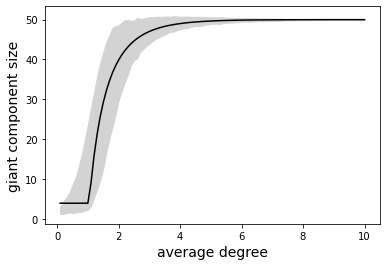

In [39]:
n = 50
# n=10000
gc_avg = []
gc_std = []
REP = 1000 ## repeats
ad = np.arange(.1,10.1,.1)
for d in ad:
    x = []
    for rep in range(REP):
        p = d/(n-1)
        g = ig.Graph.Erdos_Renyi(n=n, p=p)
        x.append(g.clusters().giant().vcount())
    gc_avg.append(np.mean(x))
    gc_std.append(np.std(x))

## theoretical
th = [np.log(n) for i in np.arange(.1,1.1,.1)]
from scipy.optimize import fsolve
def fn(x,d):
    return x+np.exp(-x*d)-1
for i in np.arange(1.1,10.1,.1):
    th.append(n*fsolve(fn,1,args=(i))[0])

plt.fill_between(ad,[x[0]-1.654*x[1] for x in zip(gc_avg,gc_std)],
                 [x[0]+1.645*x[1] for x in zip(gc_avg,gc_std)],color='lightgray')
plt.plot(ad,th,color='black')
plt.xlabel('average degree',fontsize=14)
plt.ylabel('giant component size',fontsize=14);
#plt.savefig('giant_100.eps');

## Figure 2.2: Pr(graph is connected)

* again for random graphs
* we try $n=100$ and $n=10000$ below

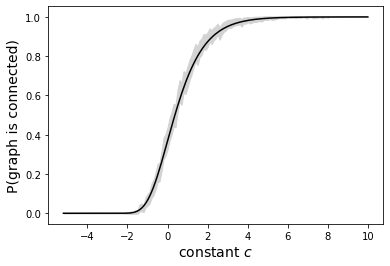

In [41]:
n = 200
# n = 10000
REP = 1000 ## repeats
lo = -int(np.floor(np.log(n)*10))/10
if lo<-10:
    lo = -10
C = np.arange(lo,10.1,.1)
ic_avg=[]
for c in C:
    x = []
    for rep in range(REP):
        p = (c+np.log(n))/n
        g = ig.Graph.Erdos_Renyi(n=n, p=p)
        x.append(int(g.is_connected()))
    ic_avg.append(np.mean(x))

## theoretical
th = [np.exp(-np.exp(-c)) for c in C]

## plot
plt.fill_between(C,[x-1.654*np.sqrt(x*(1-x)/n) for x in ic_avg],
                 [x+1.645*np.sqrt(x*(1-x)/n) for x in ic_avg],color='lightgray')
plt.plot(C,th,color='black')
plt.xlabel(r'constant $c$',fontsize=14)
plt.ylabel('P(graph is connected)',fontsize=14);
#plt.savefig('connected_100.eps');

## Figure 2.4: Distribution of shortest path lengths

For random graphs of varying size.

In [5]:
g.clusters().giant()


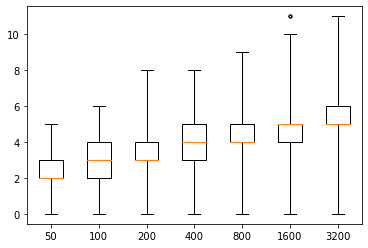

In [6]:
sp = []
N = [50,100,200,400,800,1600,3200]
for n in N:
    p = 5/(n-1)
    ## keep giant component
    g = ig.Graph.Erdos_Renyi(n=n, p=p).clusters().giant()
    z = g.shortest_paths()
    sp.append([x for y in z for x in y])
## plot    
plt.boxplot(sp, labels=N, sym='.',whis=5);
# plt.savefig('path_len.eps')

## Figure 2.5 Poisson vs degree distributions

* for random graphs
* we try $n=100$ and $n=10000$ below


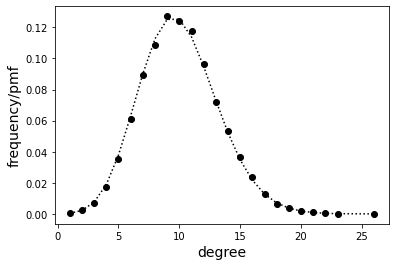

In [7]:
# n = 100
n = 10000
p = 10/(n-1)
g = ig.Graph.Erdos_Renyi(n=n, p=p)
x = [x[0] for x in sorted(Counter(g.degree()).items())]
pmf = [poisson.pmf(k,10) for k in x]
frq = [x[1]/n for x in sorted(Counter(g.degree()).items())]
plt.plot(x,frq,'o',color='black')
plt.plot(x,pmf,':',color='black')
plt.xlabel('degree',fontsize=14)
plt.ylabel('frequency/pmf',fontsize=14);


## Figure 2.6 --  Power law graphs

* We generate a power law graph and use the 'plfit' package to model its degree distribution.
* We use the Chung-Lu model, so there can be isolated nodes
* We discard 0-degree nodes as they yield errors
* Plots are from the plfit package https://pypi.org/project/plfit/

In [8]:
## fast Chung-Lu: generate m edges w.r.t. distribution d
def fastCL(d, m):
    n = len(d)
    s = np.sum(d)
    p = [i/s for i in d]
    target = m
    tples = []
    while len(tples) < target:
        s = target - len(tples)
        e0 = np.random.choice(n, size=s, replace=True, p=p)
        e1 = np.random.choice(n, size=s, replace=True, p=p)
        tples.extend([(min(e0[i],e1[i]),max(e0[i],e1[i])) for i in range(len(e0)) if e0[i]!=e1[i]]) ## ignore loops
        tples = list(set(tples)) ## drop collisions
    return tples


In [9]:
## power law graph
gamma = 2.1
n = 10000
delta = 1
Delta = np.sqrt(n)
W = []
for i in np.arange(1,n+1):
    W.append(delta * (n/(i-1+n/(Delta/delta)**(gamma-1)))**(1/(gamma-1)))

deg = [int(np.round(w)) for w in W]
m = int(np.mean(deg)*n/2)
tpl = fastCL(deg,m)
g1 = ig.Graph.TupleList(tpl)

## number of isolated nodes
iso = n-g1.vcount()
print('isolates:',iso)


isolates: 1773


(6, 2.337752978975316)


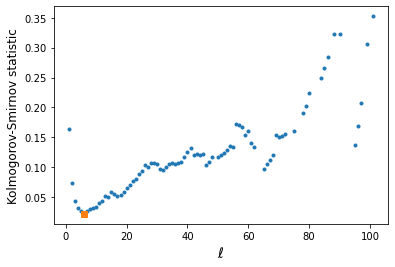

In [10]:
## KS statistic
d = g1.degree()
X = plfit.plfit(d)
print(X.plfit())
ax = plt.figure(1)
ax = X.xminvsks()
ax.set_xlabel(r'$\ell$',fontsize=14)
ax.set_ylabel('Kolmogorov-Smirnov statistic',fontsize=12);

In [11]:
## KS test, this can take a few minutes
KS_tst = X.test_pl(niter=100)

p(100) = 0.840


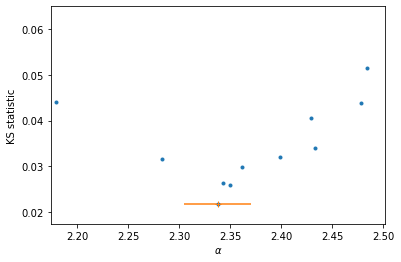

In [12]:
ax = plt.figure(1)
ax = X.alphavsks()

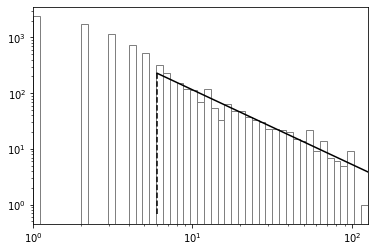

In [13]:
ax = plt.figure(2)
ax = X.plotpdf(plcolor='k',histcolor='grey')


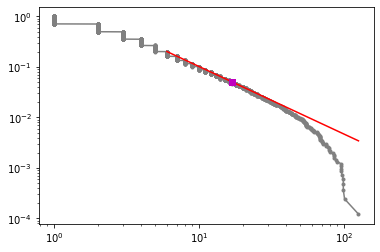

In [14]:
#ax = plt.figure(4)
X.plotcdf(pointcolor='grey', pointmarker='.',zoom=False)


## Figure 2.7: simple d-regular graphs

* We empirically compute the probability that a d-regular graph is simple.
* we use n=100 and n=10000 below

In [15]:
n = 100
# n = 10000
REP = 100
D = np.arange(2,11) 
simple = []
for d in D:
    x = 0
    for rep in range(REP):
        g = ig.Graph.Degree_Sequence([d for i in range(n)])
        x += int(g.is_simple())
    simple.append(x/REP)
th = [np.exp(-(d*d-1)/4) for d in D]

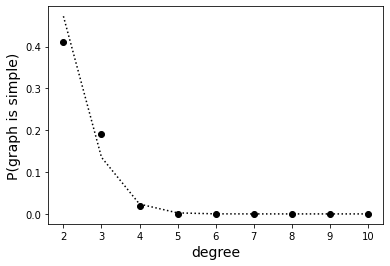

In [16]:
plt.plot(D,simple,'o',color='black')
plt.plot(D,th,':',color='black')
plt.xlabel('degree',fontsize=14)
plt.ylabel('P(graph is simple)',fontsize=14);

# Part 2 -- Experiments section

* We consider a real graph and compare some statistics with random graphs. 
* We use the GitHub ml developers graph that we introduced in Chapter 1.


In [17]:
## read the GitHub edge list into a graph (gh)
D = pd.read_csv(datadir+'GitHubDevelopers/musae_git_edges.csv')
tuples = [tuple(x) for x in D.values]
gh = ig.Graph.TupleList(tuples, directed = False)

## Add some node features;
## There are 2 class of nodes
## 0: web developer (red), 1: ml developer (blue)
X = pd.read_csv(datadir+'GitHubDevelopers/musae_git_target.csv')
idx = [int(i) for i in gh.vs['name']]
sorterIndex = dict(zip(idx,range(len(idx))))
X['Rank'] = X['id'].map(sorterIndex)
X.sort_values(['Rank'], ascending=[True],inplace=True)
X.dropna(inplace=True)
gh.vs['target'] = list(X['ml_target'])
cls = ['grey','black']
gh.vs['color'] = [cls[i] for i in list(X['ml_target'])]
gh.es['color'] = 'grey'

In [18]:
## for github, 9739 are ml developers, build the subgraph
gh_ml = gh.subgraph([v for v in gh.vs() if v['color']=='black'])

## keep the giant component
sg = gh_ml.clusters().giant()

In [19]:
def baseStats(G):
    deg = G.degree()
    return [G.vcount(),G.ecount(),np.min(deg),np.mean(deg),np.median(deg),np.max(deg),G.diameter(),
     np.max(G.clusters().membership)+1,G.clusters().giant().vcount(),sum([x==0 for x in G.degree()]),
     G.transitivity_undirected(),G.transitivity_avglocal_undirected()]
  

In [20]:
S = []
S.append(['Base Graph'] + baseStats(sg))
## Random (Erdos-Renyi) graph with same number of nodes and edges
er = ig.Graph.Erdos_Renyi(n=sg.vcount(), m=sg.ecount())
S.append(['Erdos-Renyi'] + baseStats(er))
## Random (Chung-Lu) graph with same degree distribution
tpl = fastCL(sg.degree(),sg.ecount()) 
cl = ig.Graph.Erdos_Renyi(n=sg.vcount(),m=0)
cl.add_edges(tpl)
S.append(['Chung-Lu'] + baseStats(cl))
## Random (configuration model) graph with same degree distribution
cm = ig.Graph.Degree_Sequence(sg.degree(),method='simple')
S.append(['Configuration'] + baseStats(cm))
## Random graph with same degree distribution using the
## configuration model with VL method, which yield a simple graph
cmvl = ig.Graph.Degree_Sequence(sg.degree(),method='vl')
S.append(['Configuration (VL)'] + baseStats(cmvl))


In [21]:
## Store in dataframe and compare results
D = pd.DataFrame(S,columns=['graph','nodes','edges',r'$d_{min}$',r'$d_{mean}$',
                             r'$d_{median}$',r'$d_{max}$','diameter','components','largest','isolates',
                             r'$C_{glob}$',r'$C_{loc}$'])
D = D.transpose()
D

,0,1,2,3,4
graph,Base Graph,Erdos-Renyi,Chung-Lu,Configuration,Configuration (VL)
nodes,7083,7083,7083,7083,7083
edges,19491,19491,19491,19491,19491
$d_{min}$,1,0,0,1,1
$d_{mean}$,5.5036,5.5036,5.5036,5.5036,5.5036
$d_{median}$,2,5,3,2,2
$d_{max}$,482,17,415,482,482
diameter,13,10,10,10,11
components,1,27,1002,58,1
largest,7083,7057,6059,6967,7083


In [22]:
er.vcount()


7083

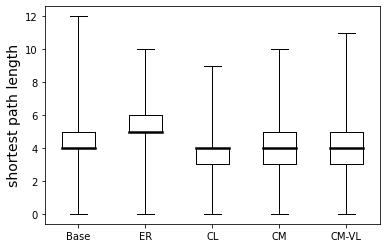

In [23]:
## compute min path length distribution for several node pairs for the 5 graphs (real and 4 random ones)
## sampling -- doing all vertices is slower
size = 500

# base subgraph
sp_sg = []
for v in np.random.choice(sg.vcount(),size=size,replace=False):
    sp_sg.extend(sg.shortest_paths(source=v)[0])

# ER
sp_er = []
for v in np.random.choice(er.vcount(),size=size,replace=False):
    sp_er.extend(er.shortest_paths(source=v)[0])

## CL
cl_g = cl.clusters().giant()
sp_cl = []
for v in np.random.choice(cl_g.vcount(),size=size,replace=False):
    sp_cl.extend(cl_g.shortest_paths(source=v)[0])

## CM
cm_g = cm.clusters().giant()
sp_cm = []
for v in np.random.choice(cm_g.vcount(),size=size,replace=False):
    sp_cm.extend(cm_g.shortest_paths(source=v)[0])

## CM-VL
sp_cmvl = []
for v in np.random.choice(cmvl.vcount(),size=size,replace=False):
    sp_cmvl.extend(cmvl.shortest_paths(source=v)[0])
    
plt.boxplot([sp_sg,sp_er,sp_cl,sp_cm,sp_cmvl],labels=['Base','ER','CL','CM','CM-VL'],
            sym='.',whis=10, medianprops = dict(linestyle='-', linewidth=2.5,color='black'))
#plt.boxplot([sp_er,sp_cl,sp_cm,sp_cmvl],labels=['ER','CL','CM','CM-VL'],
#            sym='.',whis=10, medianprops = dict(linestyle='-', linewidth=2.5,color='black'))
plt.ylabel('shortest path length',fontsize=14);
#plt.savefig('pathlen_box.eps');

## More power law tests - Grid and GitHub graphs

again with plfit package and plots

(15, 2.6233219324266894)


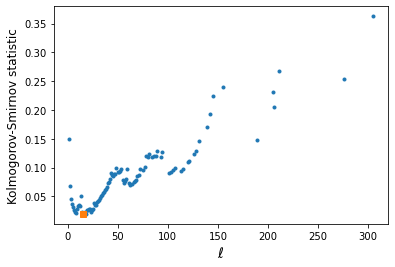

In [24]:
## for github, 9739 are ml developers, build the subgraph
gh_ml = gh.subgraph([v for v in gh.vs() if v['color']=='black'])
## keep the giant component
sg = gh_ml.clusters().giant()

## estimates for xmin and gamma
d = sg.degree()
X = plfit.plfit(d)
print(X.plfit())
ax = plt.figure(1)
ax = X.xminvsks()
ax.set_xlabel(r'$\ell$',fontsize=14)
ax.set_ylabel('Kolmogorov-Smirnov statistic',fontsize=12);

In [25]:
## KS test -- very good fit here
KS_tst = X.test_pl(niter=100)

p(100) = 0.980


(46, 2.5059946710270755)


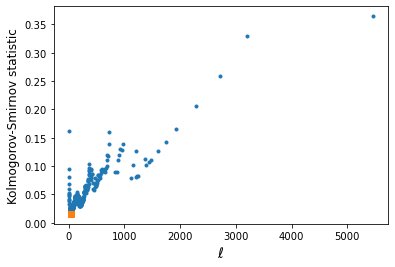

In [26]:
## github web developers subgraph
gh_web = gh.subgraph([v for v in gh.vs() if v['color']!='black'])
## keep the giant component
sg = gh_web.clusters().giant()

## estimates for xmin and gamma
d = sg.degree()
X = plfit.plfit(d)
print(X.plfit())
ax = plt.figure(1)
ax = X.xminvsks()
ax.set_xlabel(r'$\ell$',fontsize=14)
ax.set_ylabel('Kolmogorov-Smirnov statistic',fontsize=12);

In [27]:
## KS test -- not as good as previous graph, but still significant
KS_tst = X.test_pl(niter=100)

p(100) = 0.130


(15, 19.04585348531464)


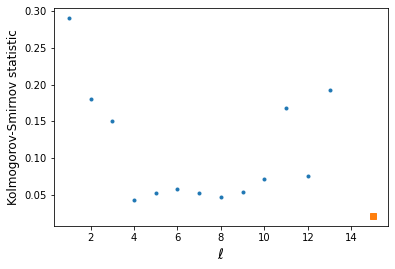

In [28]:
## now for the grid network
gr = ig.Graph.Read_Ncol(datadir+'GridEurope/gridkit_europe-highvoltage.edges', directed=False)
gr = gr.simplify()
## keep the giant component
sg = gr.clusters().giant()

## estimates for xmin and gamma
d = sg.degree()
X = plfit.plfit(d)
print(X.plfit())
ax = plt.figure(1)
ax = X.xminvsks()
ax.set_xlabel(r'$\ell$',fontsize=14)
ax.set_ylabel('Kolmogorov-Smirnov statistic',fontsize=12);

In [29]:
## we get xmin=15 ... how many nodes does this cover? --> just a few!
sum([x>=15 for x in sg.degree()])

3

In [30]:
## let's fix xmin=4 
d = sg.degree()
X = plfit.plfit(d)
print(X.plfit(xmin=4))

xmin: 4 n(>xmin): 1447 alpha: 5.86011 +/- 0.127765   Log-Likelihood: -1462.9   ks: 0.524534 p(ks): 0
(4, 5.860107700269038)


In [31]:
## KS test -- clearly not a good fit
KS_tst = X.test_pl(niter=100)

p(100) = 0.000


## Extras


In [32]:
## generate random graph with (at least one) independent set 
## n: nodes, s: independent set size, d: avg degree
def indepSet(n,s,d):
    N = n-s
    di = n*d//2-s*d
    ## random graph with N nodes
    g = ig.Graph.Erdos_Renyi(n=N,m=di)
    ## extra nodes
    g.add_vertices(s)
    ## assign remaining degree to extra nodes
    z = np.random.choice(np.arange(N,n),size=s*d)
    deg = [x[1] for x in sorted(Counter(z).items())]
    for i in range(len(deg)):
        e = np.random.choice(N,deg[i],replace=False)
        for j in e:
            g.add_edge(j,i+N)
    p = list(np.random.permutation(n))
    G = g.permute_vertices(p)
    return G


In [33]:
g = indepSet(50,10,20)
#ivs = g.independent_vertex_sets(min=10)
ivs = g.largest_independent_vertex_sets()
#ivs = g.maximal_independent_vertex_sets()
print(g.independence_number())
ivs

10


[(1, 6, 7, 11, 22, 26, 32, 35, 36, 47), (1, 6, 11, 12, 22, 26, 32, 35, 36, 47)]